In [2]:
from os import path
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt


In [19]:
base_dir = os.path.abspath(os.curdir) + r'/data'

df = pd.read_csv(path.join(os.sep, base_dir, 'Exchange Rate TWI May 1970  Aug 1995.csv'), index_col=0)
nan_df = df.copy()
df.head()

,x
1,100.0
2,99.6
3,99.4
4,99.1
5,99.2


In [24]:
df.describe()

,x
count,608.000000
mean,78.600329
std,20.531258
min,47.300000
25%,58.875000
50%,82.800000
75%,97.900000
max,121.300000


## Скользящее среднее 

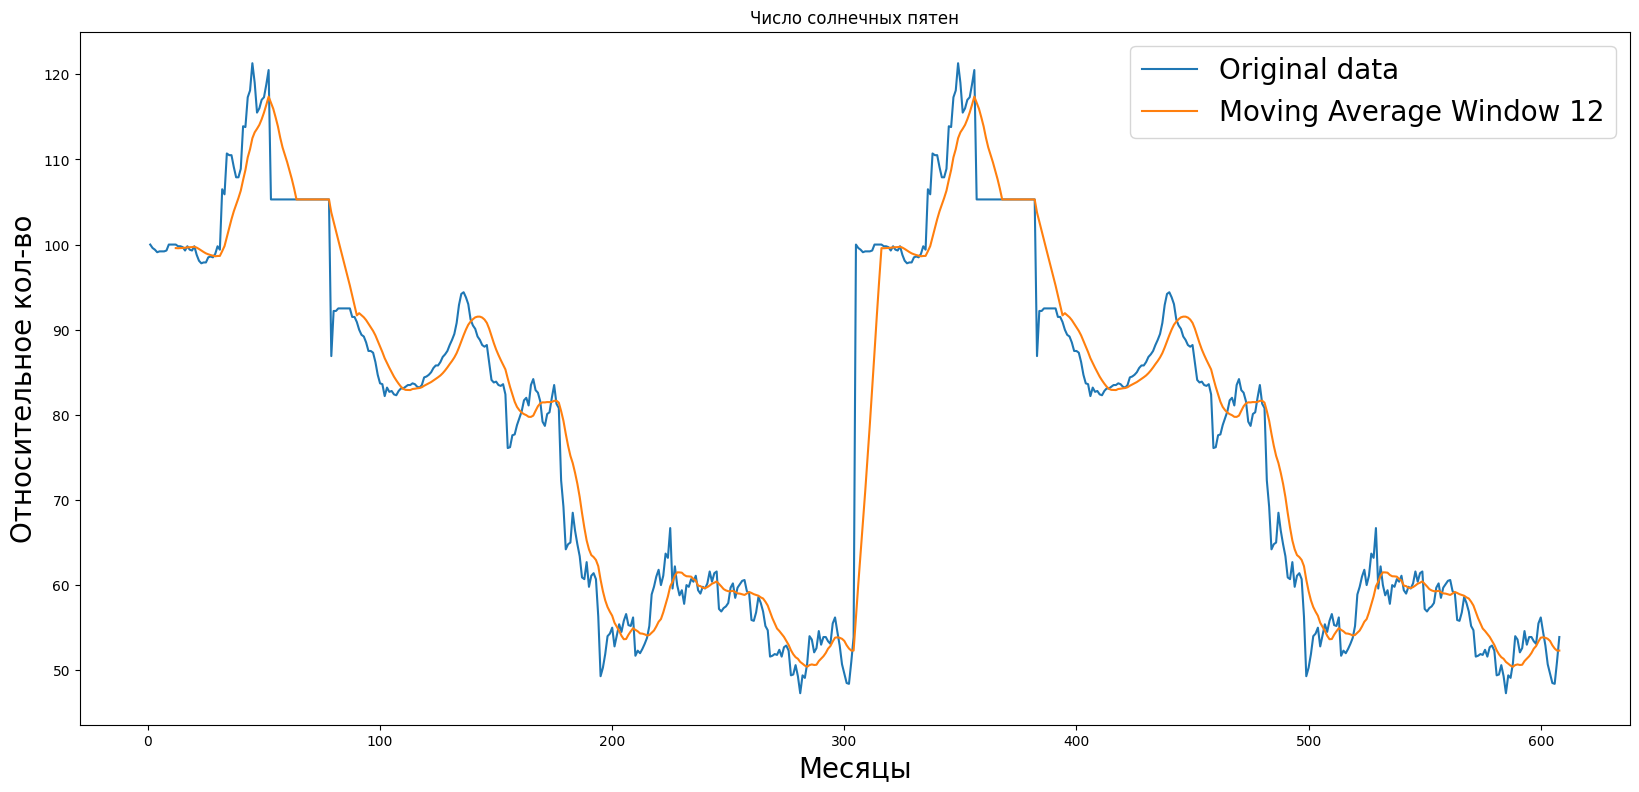

In [4]:
df['MA_window_12'] = df['x'].rolling(window=12).mean()
fig = plt.figure(figsize=(20, 9))
plt.plot(df['x'], label='Original data')
plt.plot(df['MA_window_12'], label='Moving Average Window 12')
plt.legend(fontsize="20")
plt.title('Число солнечных пятен')
plt.ylabel('Относительное кол-во', fontsize="20")
plt.xlabel('Месяцы', fontsize="20")
plt.show()

In [5]:
from statsmodels.tsa.arima.model import ARIMA

In [6]:
X = df['x'].values
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]

In [7]:
%%capture
history = [x for x in train]
arma_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arma_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

## Вывод метрик DF

In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

f_pred = arma_predictions

print("RMSE:", np.sqrt(mean_squared_error(test, f_pred)))
print("MAPE:", mean_absolute_percentage_error(test, f_pred))
print("MAE:", mean_absolute_error(test, f_pred))
print("R2: ", r2_score(test, f_pred))

RMSE: 2.010103204044702
MAPE: 0.02356181374830052
MAE: 1.4007659968334834
R2:  0.9591680095737984


In [9]:
history = [x for x in train]
arima_predictions = list()
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    arima_predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [10]:
f_pred = arima_predictions

print("RMSE:", np.sqrt(mean_squared_error(test, f_pred)))
print("MAPE:", mean_absolute_percentage_error(test, f_pred))
print("MAE:", mean_absolute_error(test, f_pred))
print("R2: ", r2_score(test, f_pred))

RMSE: 1.9880583492880124
MAPE: 0.0237806786071255
MAE: 1.417647627399176
R2:  0.9600587095068305


## Работа с пропусками

<Axes: >

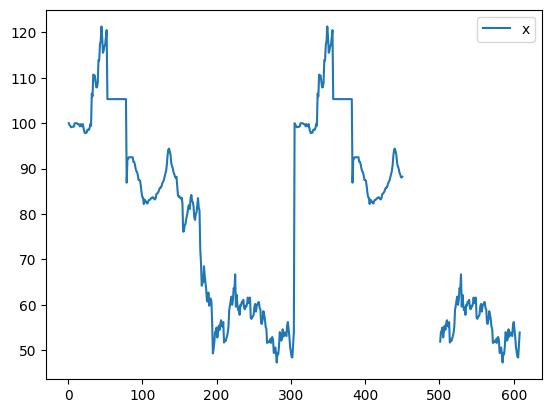

In [25]:
nw_df = nan_df.copy()

nw_df["x"][450:500] = np.nan

nw_df.plot()

<Axes: title={'center': 'Среднее из предыдущего и последующего'}>

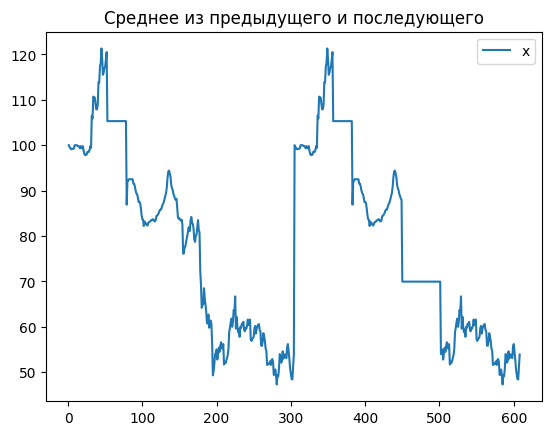

In [27]:
# Заполнение средним из предыдущего и последующего
new_value = (nw_df["x"][501] + nw_df["x"][449])/2

nw_df["x"][449:501] = new_value

nw_df.plot(title="Среднее из предыдущего и последующего")

<Axes: title={'center': 'Последующее значение'}>

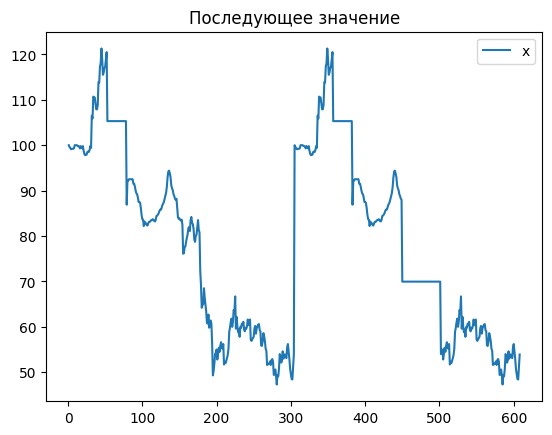

In [30]:
# Заполнение последующим значением
new_value = nw_df["x"][501]
nw_df["x"][449:501] = np.nan

nw_df["x"][449:501] = new_value

nw_df.plot(title='Последующее значение')

<Axes: title={'center': 'Медиана'}>

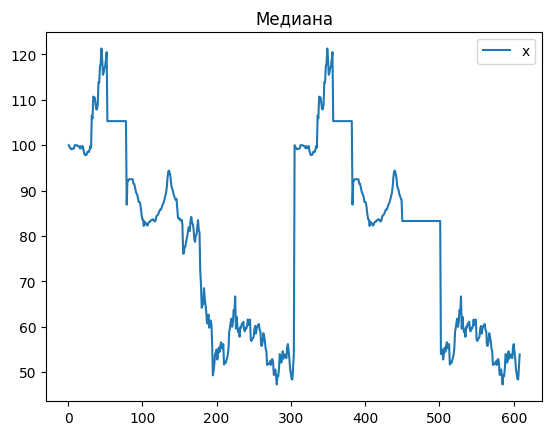

In [31]:
# Заполнение медианой
nw_df["x"][449:501] = np.nan
new_value = nw_df["x"].median()

nw_df["x"][449:501] = new_value

nw_df.plot(title='Медиана')

<Axes: title={'center': 'Среднее'}>

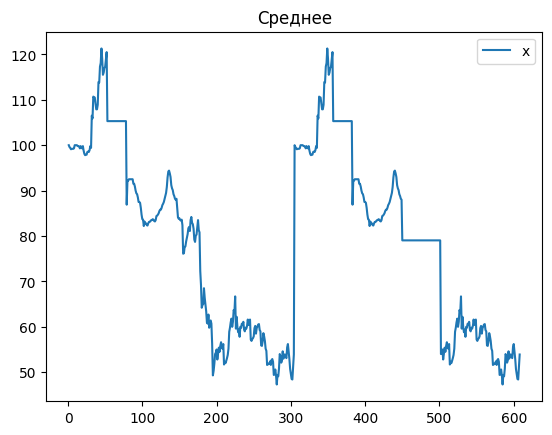

In [33]:
# Заполнение средним значением
nw_df["x"][449:501] = np.nan
new_value = nw_df["x"].mean()

nw_df["x"][449:501] = new_value

nw_df.plot(title='Среднее')


<Axes: title={'center': 'Zero'}>

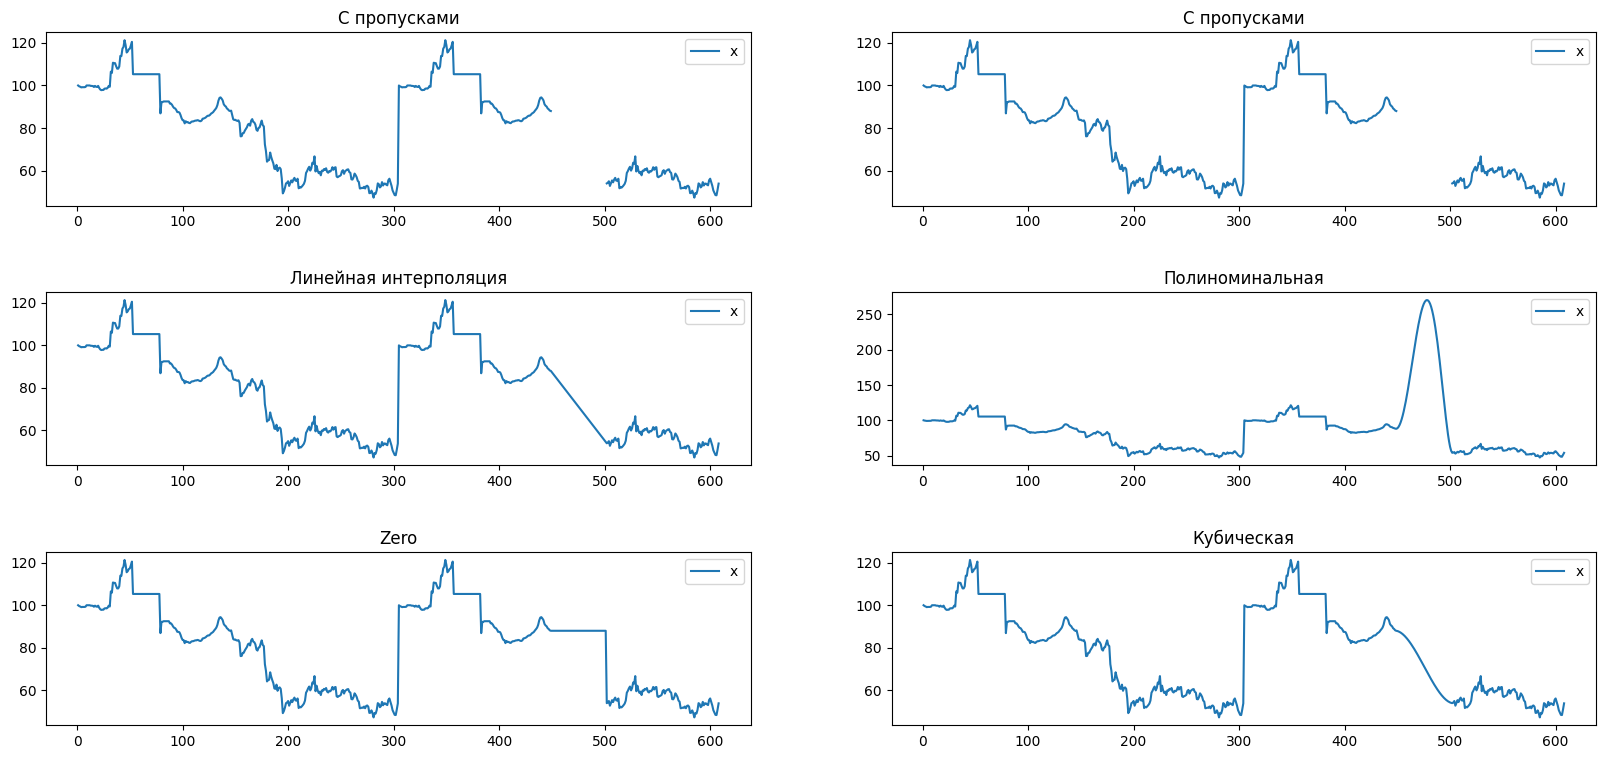

In [37]:
# Интерполяция разными алгоритмами
nw_df["x"][449:501] = np.nan

lin_df = nw_df.interpolate(method="linear")

cub_df = nw_df.interpolate(method="cubic")

pol_df = nw_df.interpolate(method="polynomial", order=5)

zero_df = nw_df.interpolate(method="zero")


fig = plt.figure(figsize=(20, 9))
layout = (3, 2)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

original_ax = plt.subplot2grid(layout, (0, 0))
lin_ax = plt.subplot2grid(layout, (1, 0))
cub_ax = plt.subplot2grid(layout, (2, 1))

pol_ax = plt.subplot2grid(layout, (1, 1))
zero_ax = plt.subplot2grid(layout, (2, 0))

nw_df.plot(title="С пропусками", ax = original_ax)
nw_df.plot(title="С пропусками", ax = plt.subplot2grid(layout, (0, 1)))
lin_df.plot(title="Линейная интерполяция", ax = lin_ax)
cub_df.plot(title="Кубическая", ax = cub_ax)
pol_df.plot(title="Полиноминальная", ax = pol_ax)
zero_df.plot(title="Zero", ax=zero_ax)

## Поиск выбросов

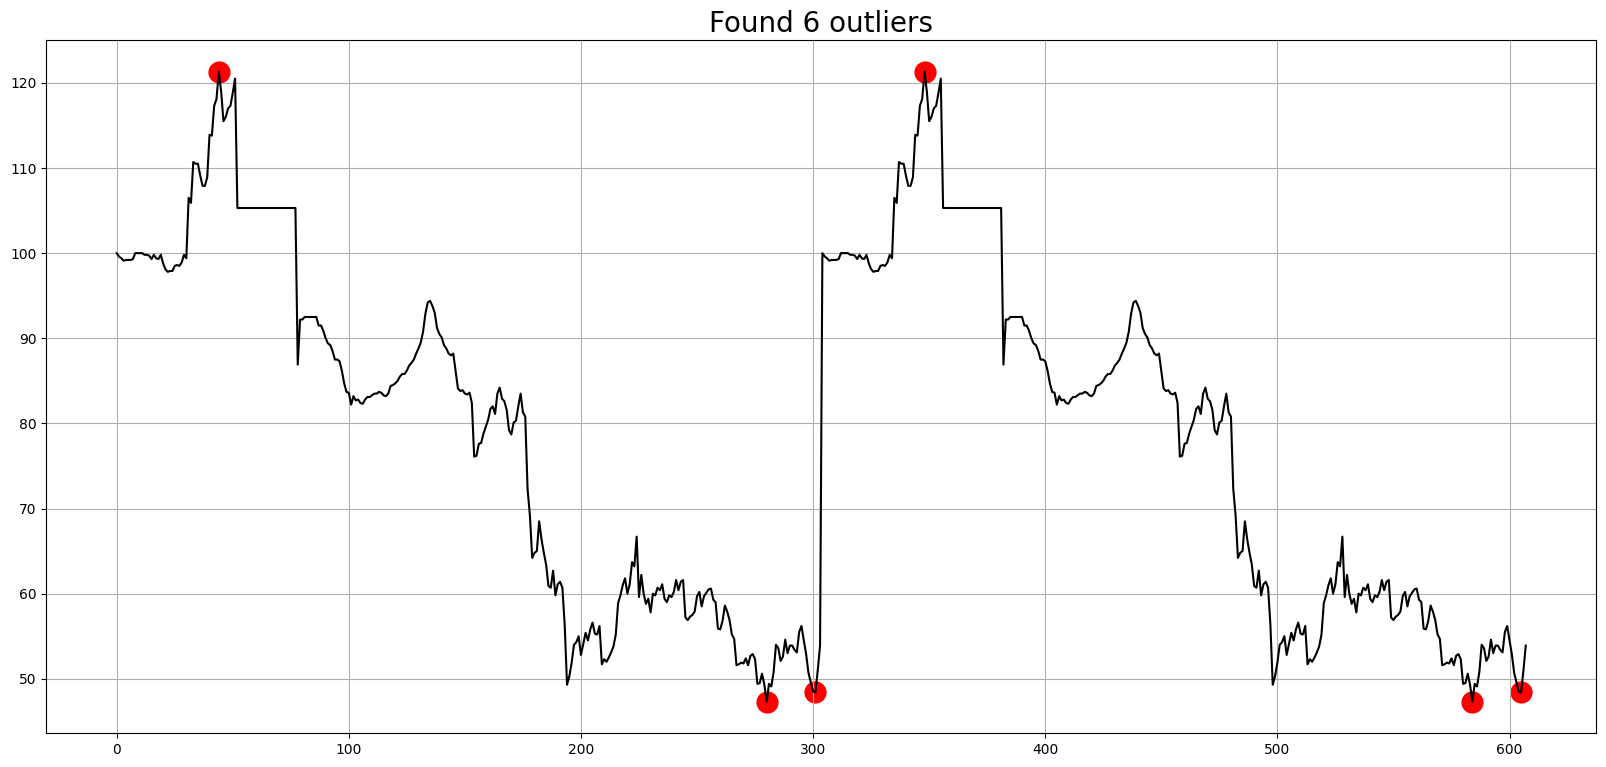

In [39]:
# Поиск выбросов
import seaborn as sns
from sklearn import preprocessing, svm
scaler = preprocessing.StandardScaler()
perc = 0.01

ecg = nan_df.copy()

local_df = ecg["x"]

ts_scaled = scaler.fit_transform(local_df.values.reshape(-1,1))
model = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
model.fit(ts_scaled)

dtf_outliers = local_df.to_frame(name="ts")
dtf_outliers["index"] = range(len(local_df))
dtf_outliers["outlier"] = model.predict(ts_scaled)
dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda x: 1 if x==-1 else 0)

fig, ax = plt.subplots(figsize=(20, 9))
ax.plot(dtf_outliers["index"], dtf_outliers["ts"], color="black")
ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1]["index"],
           y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
           color='red', linewidths=10)
plt.title(f"Found {sum(dtf_outliers['outlier']==1)} outliers", fontdict={'fontsize': 20})
ax.grid(True)
plt.show()

In [42]:
dtf_outliers.head()

,ts,index,outlier
1,100.0,0,0
2,99.6,1,0
3,99.4,2,0
4,99.1,3,0
5,99.2,4,0


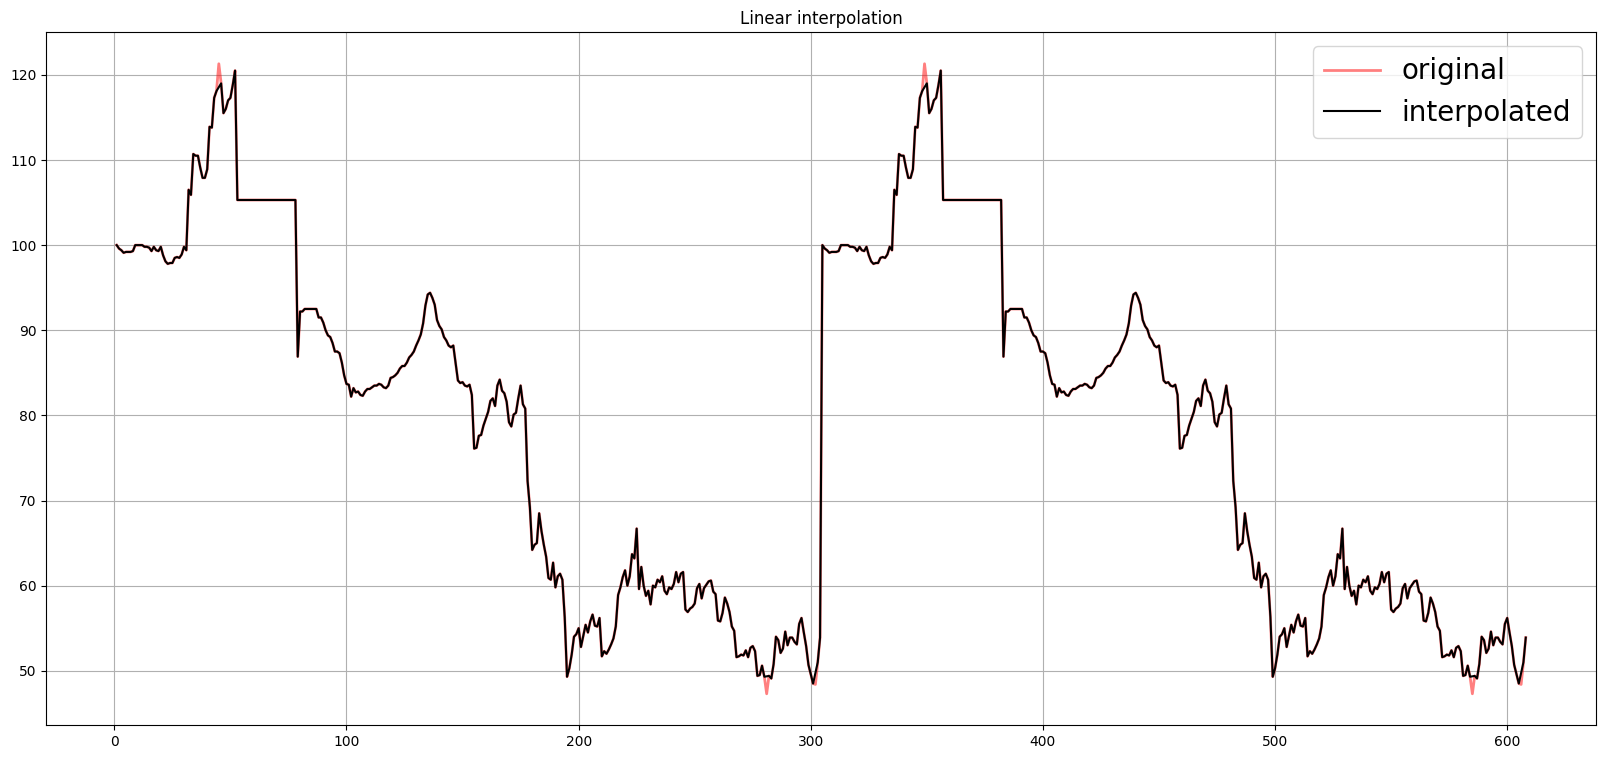

In [43]:
outliers_idx = dtf_outliers[dtf_outliers["outlier"]==1].index

ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="linear")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Linear interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()

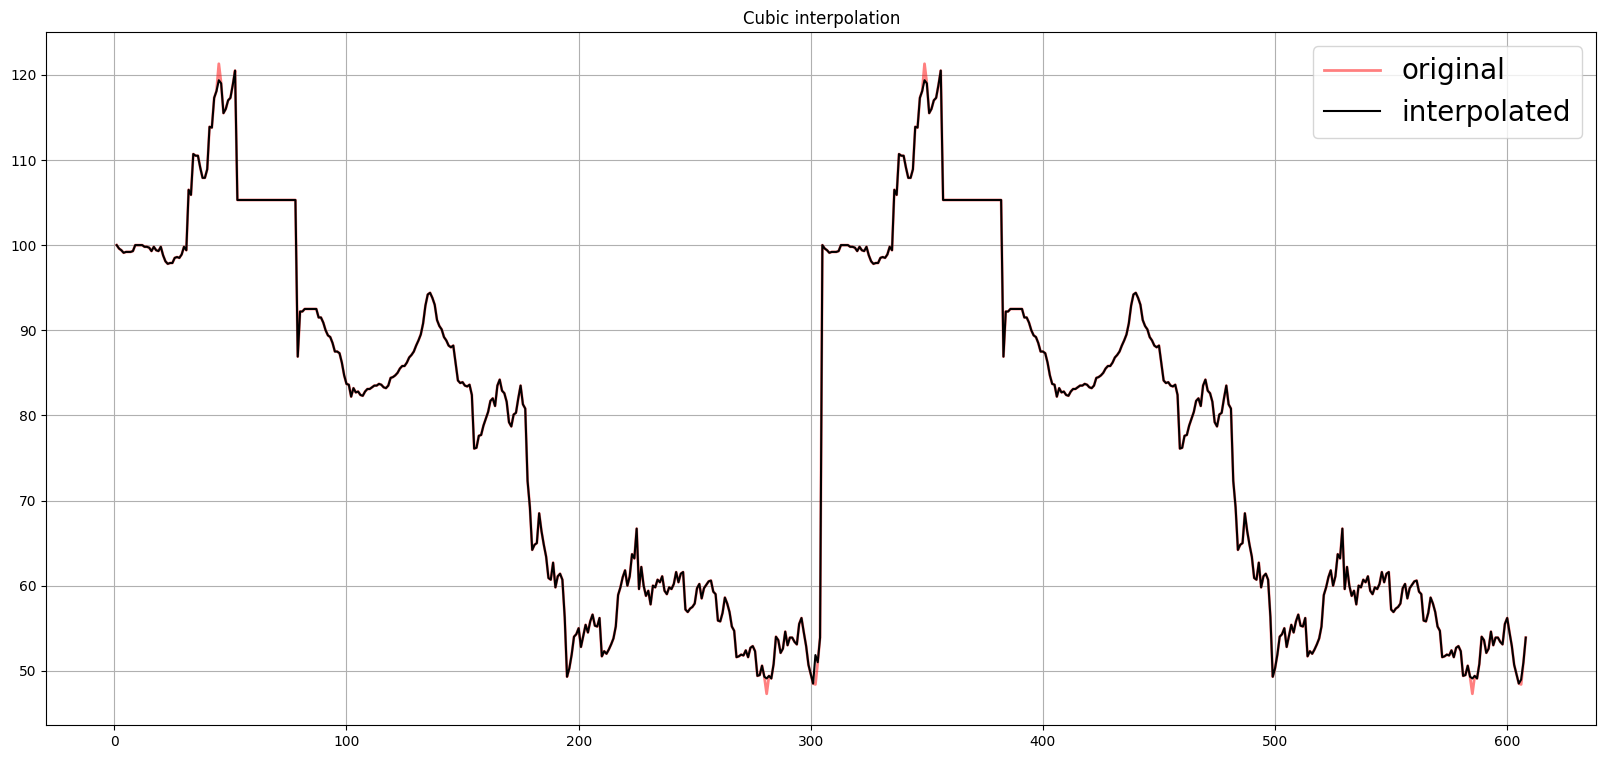

In [44]:
ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="cubic")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Cubic interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()

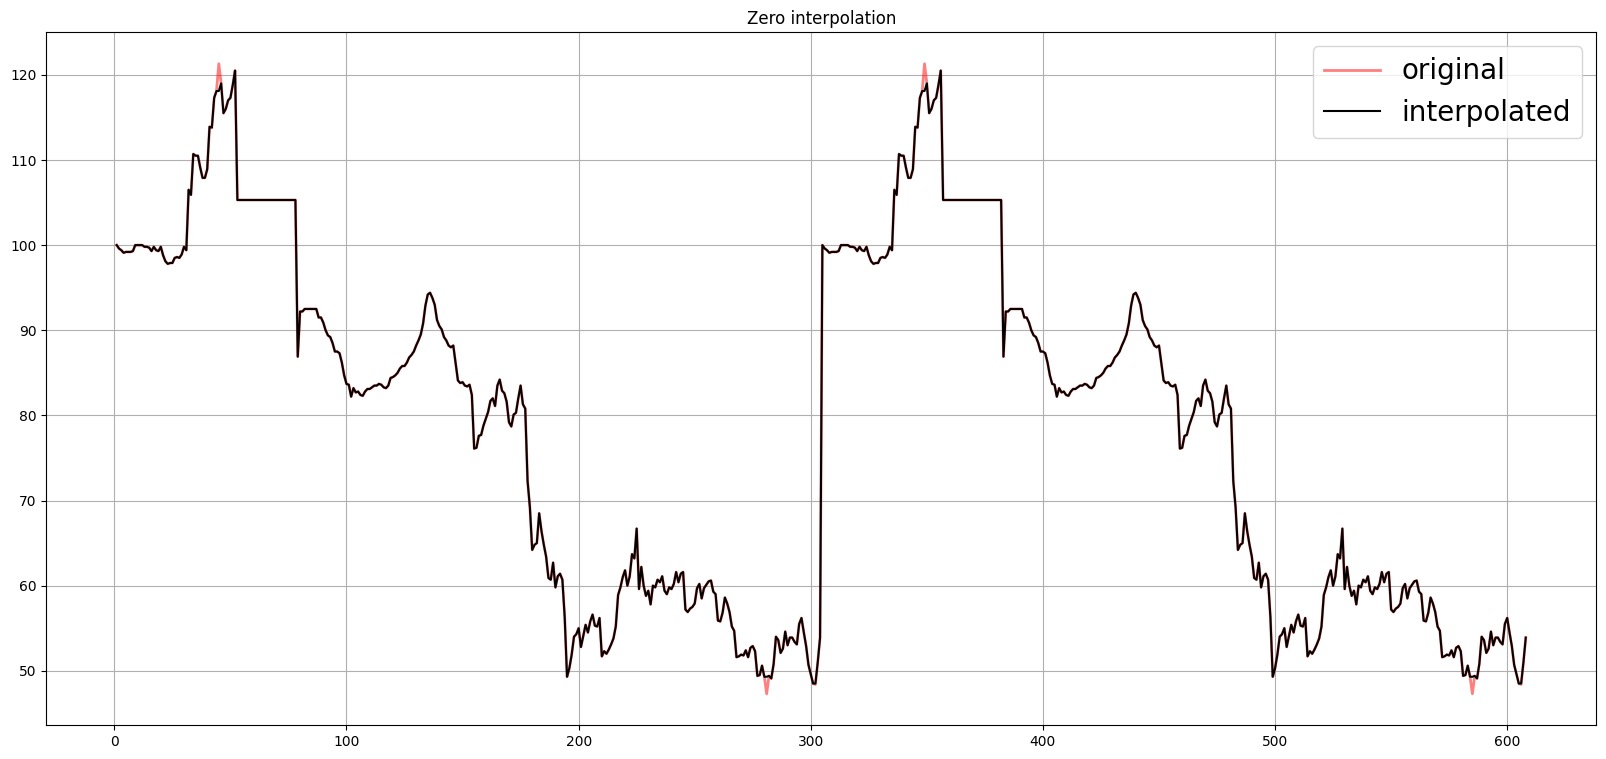

In [45]:
ts_outliers_nan = local_df.copy()
ts_outliers_nan.loc[outliers_idx] = np.nan
ts_clean = ts_outliers_nan.interpolate(method="zero")
ax = local_df.plot(figsize=(20, 9), color="red", alpha=0.5,
             title="Zero interpolation", label="original", legend=True, linewidth=2)
ts_clean.plot(ax=ax, grid=True, color="black",
              label="interpolated", legend=True)
plt.legend(fontsize="20")
plt.show()